## UNET quantitative/qualitative evaluations

In [1]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from DataGenerator_OpenCV import DataGenerator
from models_UNET import Unet
from utilities import dice, iou

In [2]:
# Instance variables
input_shape    = (768, 896, 3)
image_file_ext = r".tif"
image_xml_ext  = r".xml"
masks_file_ext = r".TIF"
test_dir_p     = "datasets-binary/test"
BASE           = 3

In [3]:
def plot_all(images):
    title = [ "Original Image (RGB)", "Ground Truth Mask", "Predicted Mask" ]
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(15,15) )
    i = 0
    
    for y in range(3):
        axes[y].set_title( title[y] )
        axes[y].imshow(images[i], cmap="gray" )
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i+=1
        
    plt.show()

In [4]:
model = Unet( input_shape, pre_trained=True, base=BASE )

Model: "Unet_base_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 896, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 768, 896, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 768, 896, 8)  224         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 768, 896, 8)  0           conv2d[0][0]                     
________________________________________________________________________________________

MODEL RESTORED Unet_base_3


In [5]:
test_img_list = [os.path.join(test_dir_p + "/images", _) for _ in os.listdir(test_dir_p + "/images") if _.endswith(image_file_ext)]
test_mask_list = [os.path.join(test_dir_p + "/masks", _) for _ in os.listdir(test_dir_p + "/masks") if _.endswith(masks_file_ext)]
# print(test_img_list)

# Create pair list
img_mask_pair_list = []
for image_fp, mask_fp in zip( test_img_list, test_mask_list):
    img_mask_pair_list.append( (image_fp, mask_fp) )

### Prediction with batch size 2

In [6]:
testDataGenerator = DataGenerator( [input_shape[0], input_shape[1], input_shape[2]], 
                                    test_img_list, 
                                    test_mask_list,
                                    batch_size=1)

X, y = testDataGenerator.__getitem__(0)
print(X.shape)
print(y.shape)

#loss, dice = model.evaluate(testDataGenerator)
loss, acc_metric = model.evaluate(testDataGenerator)
print(model.name)
print("Overall Loss: \x1b[1;31m", round(loss,4), '\x1b[0m', "Overall Dice: \x1b[1;31m", round(acc_metric,4), '\x1b[0m' )    

(1, 768, 896, 3)
(1, 768, 896, 1)
  ...
    to  
  ['...']
11/11 [==============================] - 2s 166ms/step - loss: 0.2875 - dice: 0.2176
Unet_base_3
Overall Loss:  0.2875  Overall Dice:  0.2176 


### Full Testing Set / Single prediction

Image ID: ytma49_111303_benign2_ccd.tif
Dice:  0.2083 


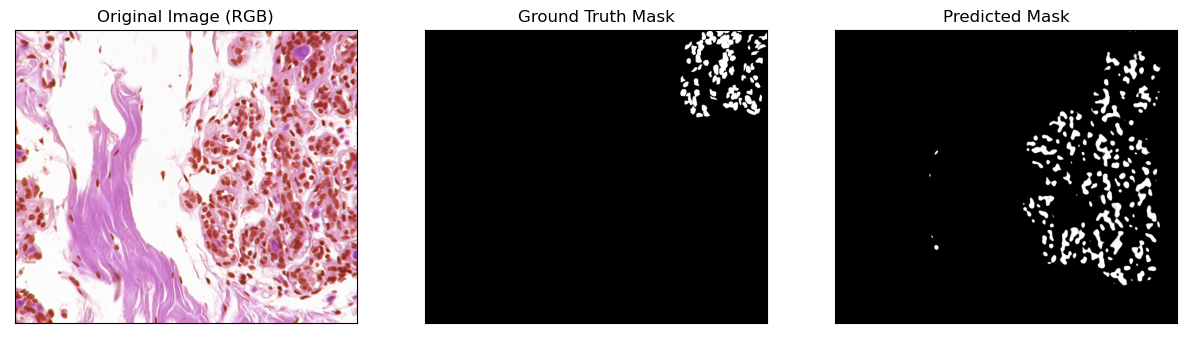

Image ID: ytma49_111303_benign3_ccd.tif
Dice:  0.4704 


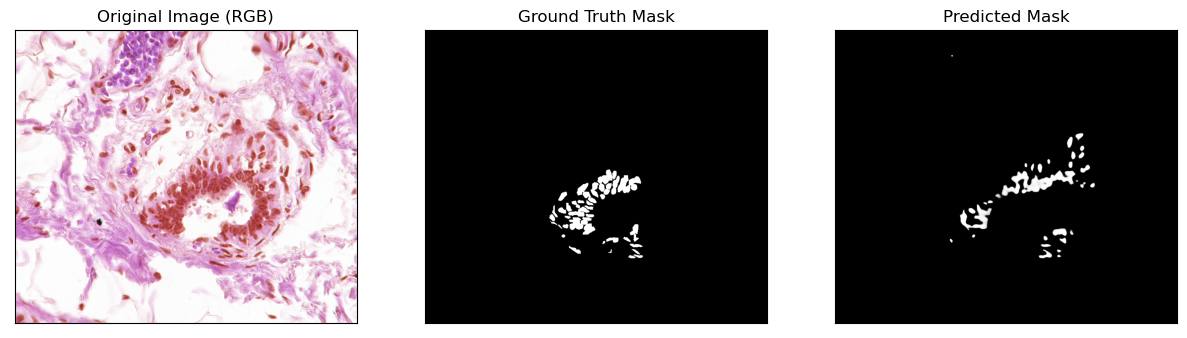

Image ID: ytma49_111303_malignant1_ccd.tif
Dice:  0.2301 


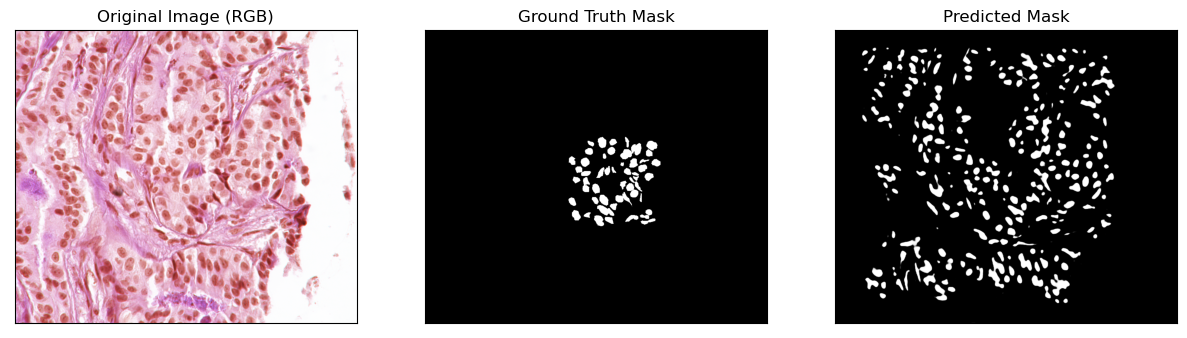

Image ID: ytma49_111303_malignant2_ccd.tif
Dice:  0.3029 


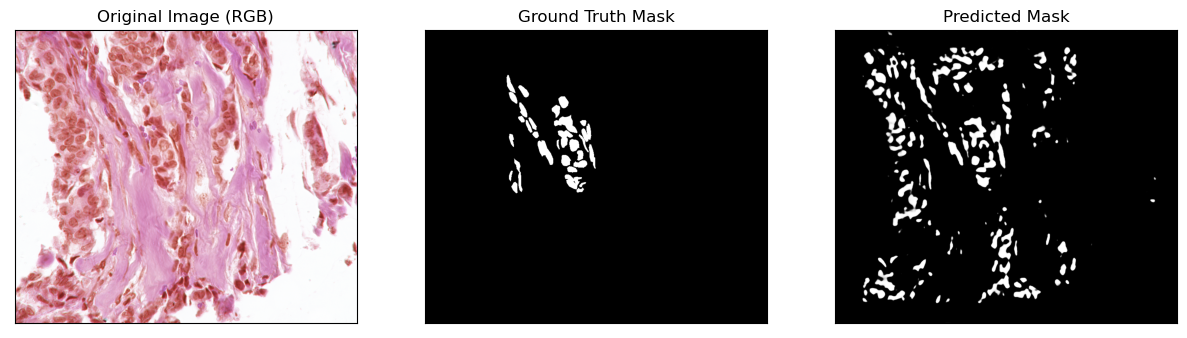

Image ID: ytma49_111303_malignant3_ccd.tif
Dice:  0.0 


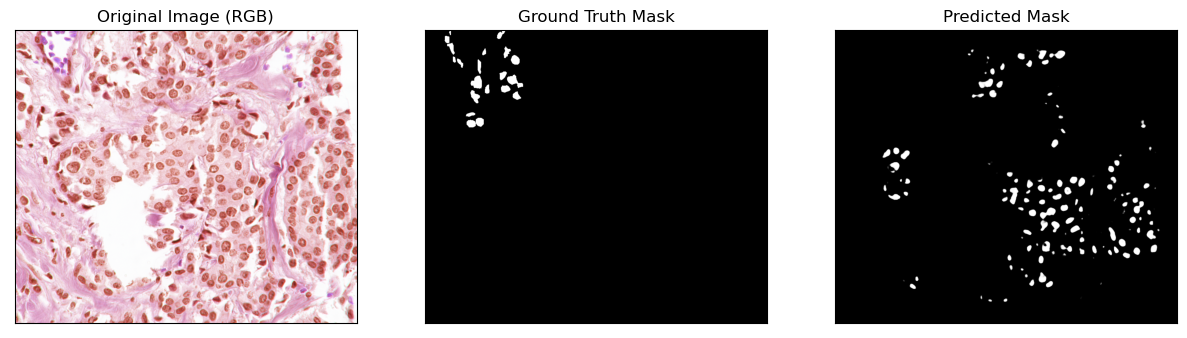

Image ID: ytma55_030603_benign1_ccd.tif
Dice:  0.1147 


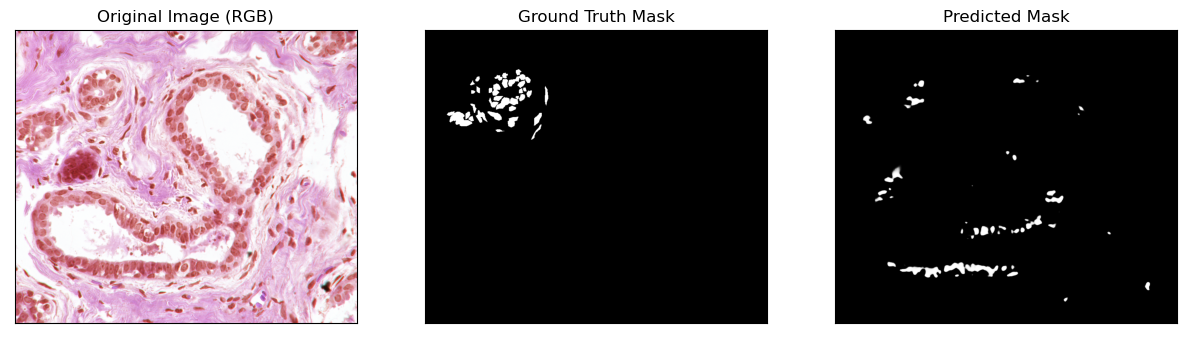

Image ID: ytma55_030603_benign2_ccd.tif
Dice:  0.0946 


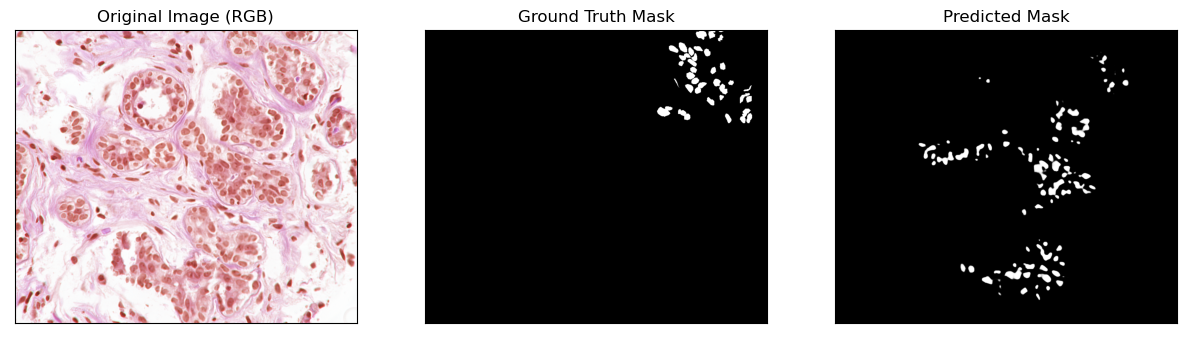

Image ID: ytma55_030603_benign3_ccd.tif
Dice:  0.3155 


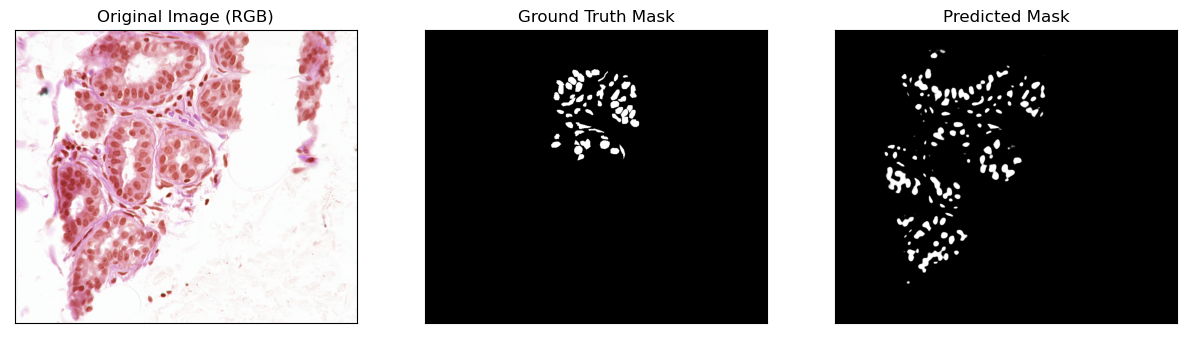

Image ID: ytma55_030603_benign4_ccd.tif
Dice:  0.1228 


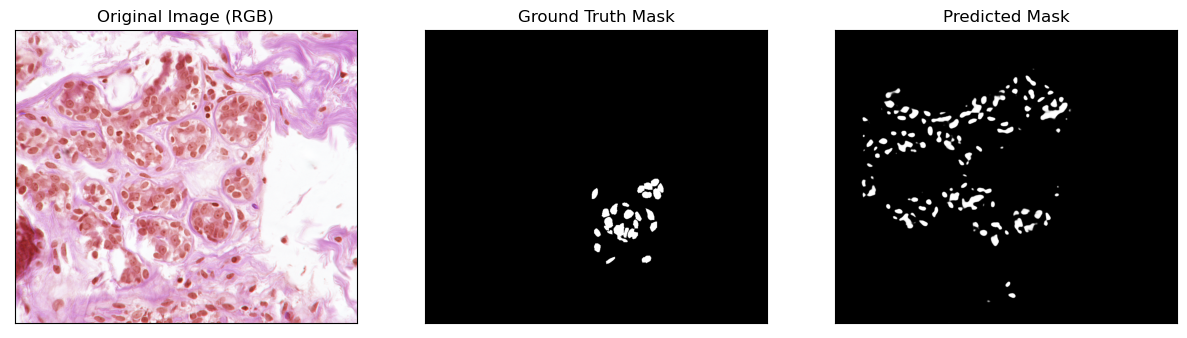

Image ID: ytma55_030603_benign5_ccd.tif
Dice:  0.534 


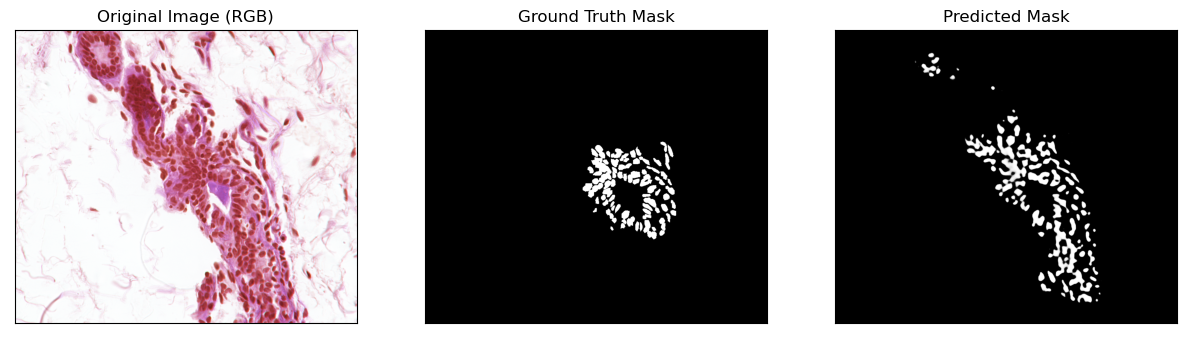

Image ID: ytma55_030603_benign6_ccd.tif
Dice:  0.0 


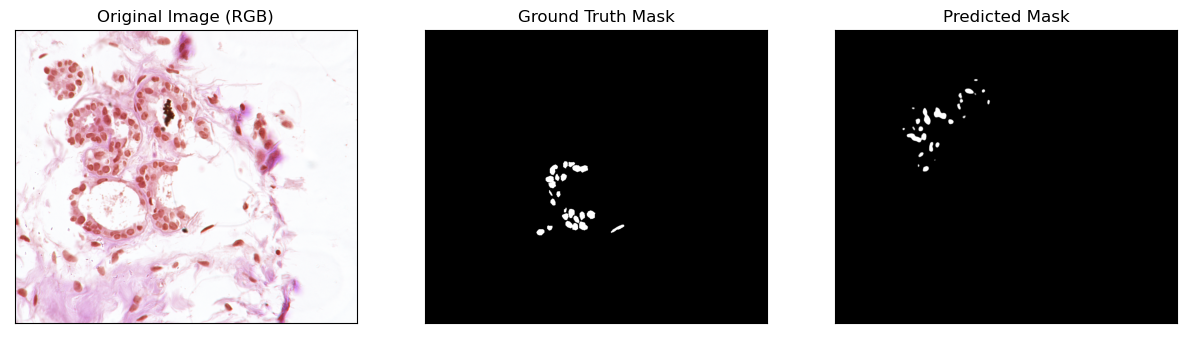

In [7]:
testDataGenerator = DataGenerator( [input_shape[0], input_shape[1], input_shape[2]], 
                                    test_img_list, 
                                    test_mask_list,
                                    batch_size=11)

for x,y in testDataGenerator.__iter__():
    
    for index, (x_i, y_i, file_n)in enumerate(zip(x, y, test_img_list)):
        
        # Predict
        single_predict = model.predict( np.expand_dims(x_i, axis=0) )
        dice_score = dice( y_i, single_predict , smooth=0 )
                
        y_predict = np.squeeze(single_predict) * 255.0
        predicted_mask = np.array(y_predict, dtype=np.uint8)
        
        # Display
        print("Image ID:",  file_n.split("\\",1)[1])
        print( "Dice: \x1b[1;31m", round(dice_score.numpy(),4), '\x1b[0m' )
        # print( "IOU: \x1b[1;31m", round(m.result().numpy()), '\x1b[0m' )
        
        plot_all([ x_i/255,
                   y_i.squeeze(),
                   predicted_mask
                  ])